In [220]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

## Ejemplo de definición de una red neuronal simple

In [213]:
n_features = 10
n_dense_neurons = 3

In [214]:
x = tf.placeholder(tf.float32, (None, n_features))
W = tf.Variable(tf.random_normal([n_features, n_dense_neurons]))
b = tf.Variable(tf.ones([n_dense_neurons]))

In [215]:
xW = tf.matmul(x, W)
z = tf.add(xW, b)
a = tf.sigmoid(z)

In [216]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    layer_out = sess.run(a, feed_dict={x:np.random.random([1, n_features])})

In [217]:
print(layer_out)

[[0.67124057 0.98852915 0.9649134 ]]


## Ejemplo de un modelo de regresión lineal simple usando TensorFlow

In [282]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline

### Ceación del conjunto de datos

Creo un conjunto de datos sintéticos adaptados a un modelo lienal pero con ruido, el total de puntos es de un millon $n=1000000$

In [354]:
x_data = np.linspace(0.0, 10.0, 1000000)
noise = np.random.randn(len(x_data))

### Definición del modelo lineal de regresión

y = mx + b

m = 0.5

b = 5

In [388]:
# Creo los valores de los datos y les agrego ruido para que no sean una recta perfecta
y_true = (0.5 * x_data) + 5 + noise

In [389]:
# Creo el DataFrame

x_df = pd.DataFrame(data=x_data, columns=['X Data'])
y_df = pd.DataFrame(data=y_true, columns=['Y'])
my_data = pd.concat([x_df, y_df], axis=1)

In [390]:
my_data.head()

,X Data,Y
0,0.00000,7.026212
1,0.00001,5.679862
2,0.00002,4.877199
3,0.00003,6.011221
4,0.00004,3.292164


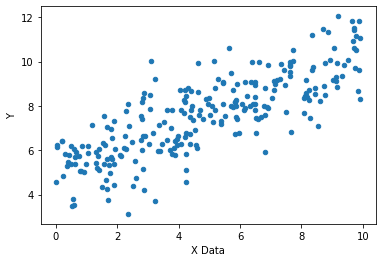

In [391]:
# selecciono algunos puntos aleatoriamente y los grafico

my_data.sample(n=250).plot(kind='scatter', x='X Data', y='Y')

## Definición de las variables y placeholders para el modelo de TensorFlow

In [359]:
batch_size = 8

# Creo los tensores para el modelo con valores aleatoreos, en este caso 0.81 para a mendiente 'm' y 
#'0.17' para el desplazamiento b del modelo

# creo las variables en TensorFlow
m = tf.Variable(0.81)
b = tf.Variable(0.17)

# creo los placeholders en TensorFlow
xph = tf.placeholder(tf.float32, [batch_size])
yph = tf.placeholder(tf.float32, [batch_size])


### Defino el modelo en tensorflow (graph)

$$ y\_model = xph * m + b $$

In [360]:
y_model = xph * m + b

### Defino la función de error

La función de error estima que tanto se aproxima el modelo calculado por TensorFlow al modelo real, en este caso se usa el error cuadratico medio

$$ error = \frac{1}{n}\sum_{i=1}^n \left(real_i - estimado_i\right)^2 $$

In [361]:
# defino la funcion de error
error = tf.divide(tf.reduce_sum(tf.square(yph - y_model)), batch_size)

### Defino el optimizador para el modelo

Se usa el modelo basado en el gradiente descendiente para buscar el mínimo de la función objetivo: $y\_model$ 

In [362]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(error)

### Defino el resto de la estructura en TensorFlow para entrenar el sistema

In [429]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    batches = 10000
    
    for i in range(batches):
        # selecciono aleatoriamente algunos de datos del conjunto de datos inicial
        rand_ind = np.random.randint(len(x_data), size=batch_size)        
        feed = {xph:x_data[rand_ind], yph:y_true[rand_ind]}
        
        # evaluo el tensor que minimiza el error del modelo
        sess.run(train, feed_dict = feed)

    model_m, model_b = sess.run([m, b])
    model_mse = sess.run(error, feed_dict = feed)
    
    # almacena la informacion necesaria para poder hacer una depuracion usando tensorboard
    writer = tf.summary.FileWriter(logdir='./first_graph', graph=sess.graph)
    writer.close()

In [428]:
pwd

'C:\\Users\\eris'

### Muestro el resultado del modelo obtenido por TensorFlow

Según la definición de los datos, los valores para la pendiente y el desplazamiento deberian ser los siguientes: $m=0.5$ y $b=5$ mientras que el  $mse \to 0$



In [394]:
print('Pendiente: %f' % (model_m))
print('Desplazamiento: %f' % (model_b))
print('Error: %f' % (model_mse))

Pendiente: 0.507010
Desplazamiento: 4.997664
Error: 1.168094


### Muestro los datos y el modero resultante

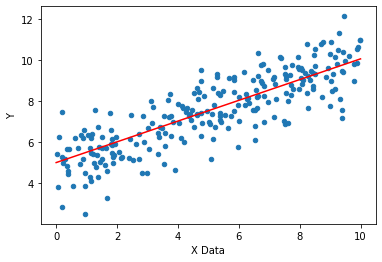

In [379]:
y_hat = x_data * model_m + model_b
my_data.sample(250).plot(kind='scatter', x='X Data', y='Y')
plt.plot(x_data, y_hat, 'r')

## Uso de estimadores en Tensorflow

In [398]:
feat_cols = [tf.feature_column.numeric_column('x', shape=[1])]
estimator = tf.estimator.LinearRegressor(feature_columns=feat_cols)

W0909 13:14:57.667801 15568 estimator.py:1811] Using temporary folder as model directory: C:\Users\eris\AppData\Local\Temp\tmpvuditqg3


In [399]:
from sklearn.model_selection import train_test_split
x_train, x_eval, y_train, y_eval = train_test_split(x_data, y_true, test_size=0.3, random_state=101)

In [402]:
input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train}, y_train, batch_size=8, num_epochs=None, shuffle=True)

In [403]:
train_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train}, y_train, batch_size=8, num_epochs=1000, shuffle=False)

In [404]:
eval_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_eval}, y_eval, batch_size=8, num_epochs=None, shuffle=True)

In [405]:
estimator.train(input_fn=input_func, steps=1000)

W0909 13:22:27.528522 15568 deprecation.py:323] From C:\Users\eris\Anaconda3\envs\tfdeeplearning\lib\site-packages\tensorflow\python\training\training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0909 13:22:27.547495 15568 deprecation.py:323] From C:\Users\eris\Anaconda3\envs\tfdeeplearning\lib\site-packages\tensorflow_estimator\python\estimator\inputs\queues\feeding_queue_runner.py:62: QueueRunner.__init__ (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
W0909 13:22:27.550465 15568 deprecation.py:323] From C:\Users\eris\Anaconda3\envs\tfdeeplearning\lib\site-packages\tensorflow_estimator\python\estimator\input

In [406]:
train_metrics = estimator.evaluate(input_fn=train_input_func, steps=1000)

W0909 13:24:34.389795 15568 deprecation.py:323] From C:\Users\eris\Anaconda3\envs\tfdeeplearning\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [407]:
train_metrics

{'average_loss': 1.0593791,
 'label/mean': 7.494222,
 'loss': 8.475033,
 'prediction/mean': 7.340083,
 'global_step': 1000}

In [408]:
eval_metrics = estimator.evaluate(input_fn=eval_input_func, steps=1000)

In [409]:
eval_metrics

{'average_loss': 1.0797122,
 'label/mean': 7.50578,
 'loss': 8.637697,
 'prediction/mean': 7.3391066,
 'global_step': 1000}

Como se observa en las siguientes lineas, el error tanto en training como en la evaluaci{on es muy similar, eso es una clara forma d ever que no existe overfitting

In [413]:
print('TRAINING DATA METRICS')
print(train_metrics)

TRAINING DATA METRICS
{'average_loss': 1.0593791, 'label/mean': 7.494222, 'loss': 8.475033, 'prediction/mean': 7.340083, 'global_step': 1000}


In [414]:
print('EVAL METRICS')
print(eval_metrics)

EVAL METRICS
{'average_loss': 1.0797122, 'label/mean': 7.50578, 'loss': 8.637697, 'prediction/mean': 7.3391066, 'global_step': 1000}


In [418]:
brand_new_data = np.linspace(0,10,10)

input_fn_predict = tf.estimator.inputs.numpy_input_fn({'x':brand_new_data}, shuffle=False)
list(estimator.predict(input_fn=input_fn_predict))

[{'predictions': array([4.3819], dtype=float32)},
 {'predictions': array([5.0389786], dtype=float32)},
 {'predictions': array([5.696057], dtype=float32)},
 {'predictions': array([6.3531356], dtype=float32)},
 {'predictions': array([7.010214], dtype=float32)},
 {'predictions': array([7.6672926], dtype=float32)},
 {'predictions': array([8.324371], dtype=float32)},
 {'predictions': array([8.981449], dtype=float32)},
 {'predictions': array([9.638529], dtype=float32)},
 {'predictions': array([10.295607], dtype=float32)}]

In [419]:
predictions = []
for pred in estimator.predict(input_fn=input_fn_predict):
    predictions.append(pred['predictions'])

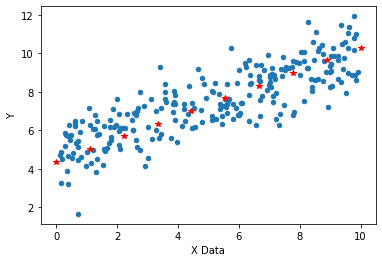

In [423]:
my_data.sample(n=250).plot(kind='scatter', x='X Data', y='Y')
plt.plot(brand_new_data, predictions, 'r*')